# ResNET Implementation

### Importing Libraries

In [1]:
import os
import random
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import copy
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from collections import Counter
from torch.utils.data import WeightedRandomSampler
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder
from torchvision.transforms import Grayscale
from torch.utils.data import DataLoader, random_split
import torch.optim as optim
import torchsummary
from tqdm import tqdm

### Data Augmentation

Defineing two image preprocessing pipelines using PyTorch’s transforms. Compose—one for training and one for validation/testing. The train_transforms pipeline includes resizing to 224×224 pixels, followed by data augmentation techniques like random horizontal and vertical flips, random rotation, and brightness/contrast jittering to improve model robustness and prevent overfitting. It then converts images to tensors and normalizes them using ImageNet’s mean and standard deviation values. The val_test_transforms pipeline is simpler, applying only resizing, tensor conversion, and normalization to ensure consistent input formatting without altering image content during evaluation.

In [2]:
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),        
    transforms.RandomHorizontalFlip(),    
    transforms.RandomRotation(20),        
    transforms.RandomVerticalFlip(),      
    transforms.ColorJitter(brightness = 0.2, contrast = 0.2),  
    transforms.ToTensor(),                
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  
])

val_test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

### Loading Dataset

Loading an image dataset from the "AlzheimerDataset" directory using PyTorch’s ImageFolder, which expects images to be organized in subdirectories named after their class labels. It applies different transformation pipelines to the training, validation, and test sets. Data augmentation for training and only resizing and normalization for validation and testing. The last two lines print out the list of class names detected in the dataset and the corresponding mapping of each class to a numeric index.

In [3]:
dataset_path = 'AlzheimerDataset'
batch_size = 32
train_data = ImageFolder(root = dataset_path, transform = train_transforms)
val_data = ImageFolder(root = dataset_path, transform = val_test_transforms)
test_data = ImageFolder(root = dataset_path, transform = val_test_transforms)
print(f'Classes: {train_data.classes}')
print(f'Class-to-Index Mapping: {train_data.class_to_idx}')

train_loader = DataLoader(train_data, batch_size = batch_size, shuffle = True, num_workers = 2)
val_loader = DataLoader(val_data, batch_size = batch_size, shuffle = False, num_workers = 2)
test_loader = DataLoader(test_data, batch_size = batch_size, shuffle = False, num_workers = 2)

Classes: ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']
Class-to-Index Mapping: {'MildDemented': 0, 'ModerateDemented': 1, 'NonDemented': 2, 'VeryMildDemented': 3}


In [4]:
batch_size = 32

train_loader = DataLoader(train_data, batch_size = batch_size, shuffle = True)
val_loader = DataLoader(val_data, batch_size = batch_size, shuffle = False)
test_loader = DataLoader(test_data, batch_size = batch_size, shuffle = False)

### Number of images per class

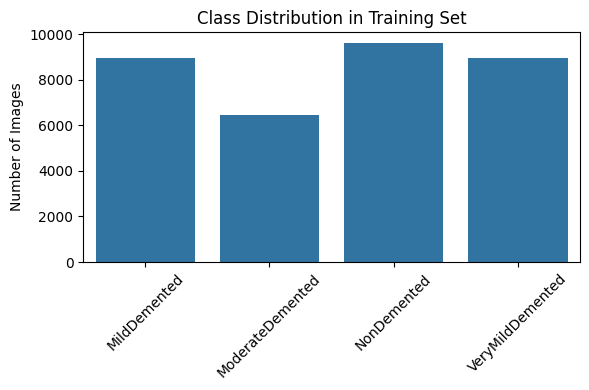

In [5]:
class_counts = Counter([label for _, label in train_data.imgs])
labels = [train_data.classes[i] for i in class_counts.keys()]
counts = list(class_counts.values())

plt.figure(figsize = (6, 4))
sns.barplot(x = labels, y = counts)
plt.title('Class Distribution in Training Set')
plt.ylabel('Number of Images')
plt.xticks(rotation = 45)
plt.tight_layout()
plt.show()

### Training data summary

Statistics

In [6]:
image_shapes = []
for path, _ in train_data.imgs:
    with Image.open(path) as img:
        image_shapes.append(img.size)

shape_df = pd.DataFrame(image_shapes, columns=['Width', 'Height'])
print(shape_df.describe())

              Width        Height
count  33984.000000  33984.000000
mean     196.233522    188.116761
std        7.819527      3.909764
min      180.000000    180.000000
25%      200.000000    190.000000
50%      200.000000    190.000000
75%      200.000000    190.000000
max      200.000000    190.000000


In [7]:
def compute_mean_std(loader):
    mean = 0.0
    std = 0.0
    total_images = 0

    for images, _ in tqdm(loader):
        batch_samples = images.size(0)
        images = images.view(batch_samples, images.size(1), -1)
        mean += images.mean(2).sum(0)
        std += images.std(2).sum(0)
        total_images += batch_samples

    mean /= total_images
    std /= total_images
    return mean, std

eda_loader = DataLoader(train_data, batch_size = 32, shuffle = False, num_workers = 2)
mean, std = compute_mean_std(eda_loader)
print('Computed Mean:', mean)
print('Computed Std:', std)

100%|███████████████████████████████████████| 1062/1062 [01:02<00:00, 16.89it/s]

Computed Mean: tensor([-0.8388, -0.7281, -0.5023])
Computed Std: tensor([1.3073, 1.3364, 1.3304])


### Random images from the dataset

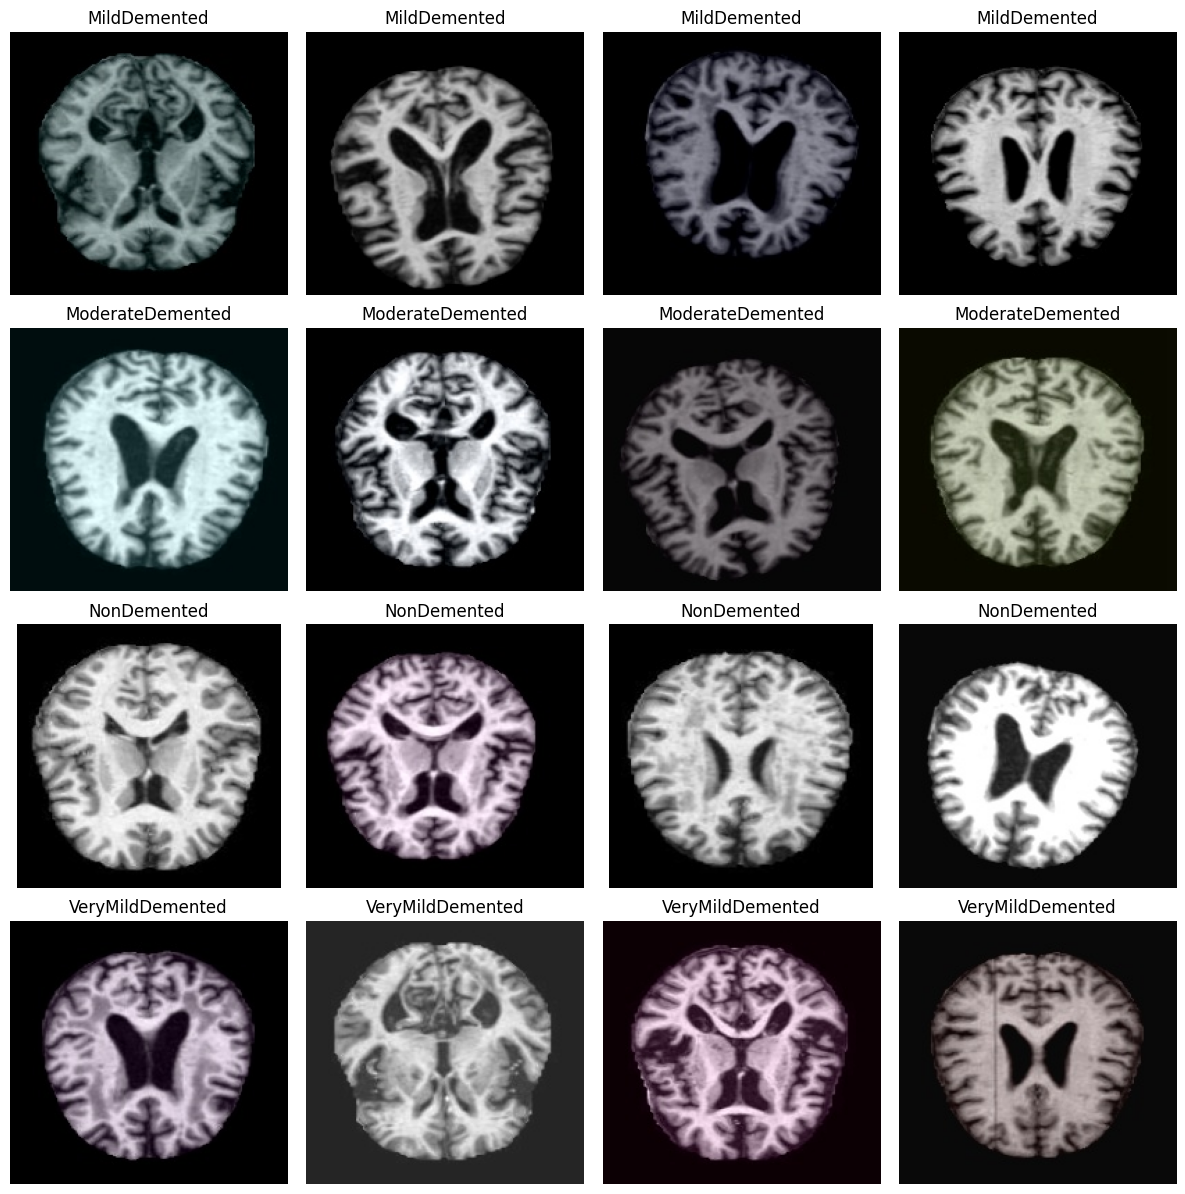

In [8]:
def show_images_by_class(dataset, class_names, samples_per_class = 4):
    fig, axes = plt.subplots(len(class_names), samples_per_class, figsize=(samples_per_class * 3, len(class_names) * 3))
    for i, class_name in enumerate(class_names):
        class_idx = dataset.class_to_idx[class_name]
        indices = [j for j, (_, label) in enumerate(dataset.imgs) if label == class_idx]
        sampled_indices = random.sample(indices, samples_per_class)
        for k, idx in enumerate(sampled_indices):
            img_path, _ = dataset.imgs[idx]
            image = Image.open(img_path)
            axes[i, k].imshow(image)
            axes[i, k].set_title(class_name)
            axes[i, k].axis('off')
    plt.tight_layout()
    plt.show()

show_images_by_class(train_data, train_data.classes)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0616211].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.015686303..1.0376734].


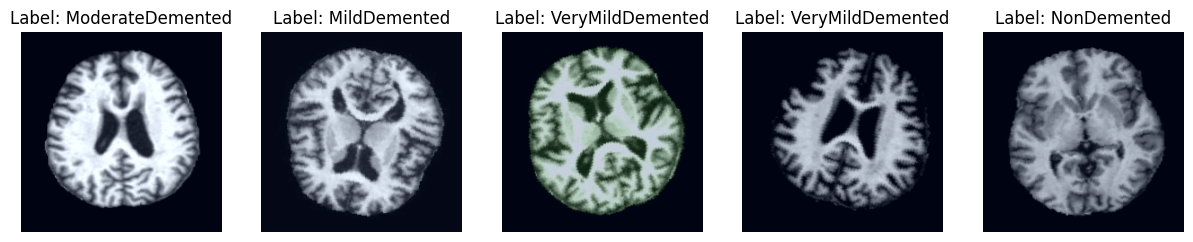

In [9]:
data_iter = iter(train_loader)
images, labels = next(data_iter)

fig, axes = plt.subplots(1, 5, figsize=(15, 5))
for i in range(5):
    image = images[i].numpy().transpose((1, 2, 0))
    image = image * 0.229 + 0.485
    axes[i].imshow(image)
    axes[i].set_title(f'Label: {train_data.classes[labels[i]]}')
    axes[i].axis('off')

plt.show()

### Balancing classes using weighted sampling

Handling class imbalance in the training dataset by applying weighted random sampling. It first counts the number of samples in each class using Counter, then computes class weights inversely proportional to their frequencies—giving higher weights to underrepresented classes. Each training sample is then assigned a corresponding weight. A WeightedRandomSampler is used to sample data such that all classes are represented more evenly during training. This sampler is passed to a DataLoader to ensure balanced batches. Finally, a message confirms that class balancing has been successfully applied.

In [10]:
class_counts = Counter(train_data.targets)
total_count = sum(class_counts.values())
class_weights = {cls: total_count / count for cls, count in class_counts.items()}
weights = [class_weights[label] for label in train_data.targets]

sampler = WeightedRandomSampler(weights, num_samples = len(weights), replacement = True)

train_loader = DataLoader(train_data, batch_size = batch_size, sampler = sampler, num_workers = 2)

print('Class balancing using weighted sampling is applied!')

Class balancing using weighted sampling is applied!


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.035294116..1.0855688].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.08956].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0017517].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.08956].


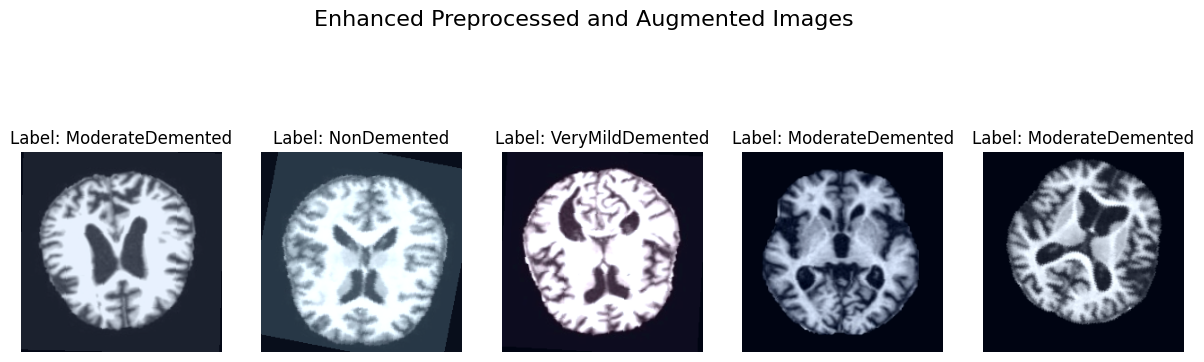

In [11]:
data_iter = iter(train_loader)
images, labels = next(data_iter)

fig, axes = plt.subplots(1, 5, figsize=(15, 5))
for i in range(5):
    image = images[i].numpy().transpose((1, 2, 0))
    image = image * 0.229 + 0.485
    axes[i].imshow(image.squeeze(), cmap='gray')
    axes[i].set_title(f'Label: {train_data.classes[labels[i]]}')
    axes[i].axis('off')

plt.suptitle('Enhanced Preprocessed and Augmented Images', fontsize = 16)
plt.show()

In [25]:
data_iter = iter(train_loader)
images, labels = next(data_iter)

print(f'Batch Size: {images.size(0)}')
print(f'Image Shape: {images.shape}')
print(f'Image Mean: {images.mean().item():.4f}, Image Std: {images.std().item():.4f}')


Batch Size: 32
Image Shape: torch.Size([32, 3, 224, 224])
Image Mean: -0.7343, Image Std: 1.3988


### Defining ResNET model

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.nn.functional as F
import time
import copy
import numpy as np
from tqdm import tqdm

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.downsample = downsample

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=4):
        super(ResNet, self).__init__()
        self.in_channels = 64

        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )

        self.layer1 = self._make_layer(block, 64, layers[0], stride=1)   
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)  
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)  
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)  

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(0.4)
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, block, out_channels, blocks, stride):
        downsample = None
        if stride != 1 or self.in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

        layers = [block(self.in_channels, out_channels, stride, downsample)]
        self.in_channels = out_channels

        for _ in range(1, blocks):
            layers.append(block(out_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = self.fc(x)

        return x

def ResNet18(num_classes=4):
    return ResNet(ResidualBlock, [2, 2, 2, 2], num_classes)

In [14]:
model = ResNet18(num_classes=4)
print(sum(p.numel() for p in model.parameters() if p.requires_grad))
print(model)

11178564
ResNet(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (layer1): Sequential(
    (0): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


### Training the model

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import copy
from tqdm import tqdm

def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()
    
    train_loss, train_acc, val_loss, val_acc = [], [], [], []
    
    best_acc = 0.0
    best_model_wts = copy.deepcopy(model.state_dict())
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        model.train()
        epoch_train_loss = 0.0
        epoch_train_corrects = 0
        
        for inputs, labels in tqdm(train_loader, desc=f'Training epoch {epoch+1}'):
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            with torch.set_grad_enabled(True):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
            epoch_train_loss += loss.item() * inputs.size(0)
            epoch_train_corrects += torch.sum(preds == labels.data)
        
        if scheduler is not None:
            scheduler.step()
        
        epoch_train_loss /= len(train_loader.dataset)
        epoch_train_acc = epoch_train_corrects.float() / len(train_loader.dataset)
        
        train_loss.append(epoch_train_loss)
        train_acc.append(epoch_train_acc.cpu().numpy())
        
        print(f'Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_acc:.4f}')
        
        model.eval()
        epoch_val_loss = 0.0
        epoch_val_corrects = 0
        
        for inputs, labels in tqdm(val_loader, desc=f'Validation epoch {epoch+1}'):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            with torch.no_grad():
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)
            
            epoch_val_loss += loss.item() * inputs.size(0)
            epoch_val_corrects += torch.sum(preds == labels.data)
        
        epoch_val_loss /= len(val_loader.dataset)
        epoch_val_acc = epoch_val_corrects.float() / len(val_loader.dataset)
        
        val_loss.append(epoch_val_loss)
        val_acc.append(epoch_val_acc.cpu().numpy())
        
        print(f'Validation Loss: {epoch_val_loss:.4f} Validation Accuracy: {epoch_val_acc:.4f}\n')
        
        if epoch_val_acc > best_acc:
            best_acc = epoch_val_acc
            torch.save(model.state_dict(), "best_model.pt")
    
    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed//60:.0f}m {time_elapsed%60:.0f}s')
    print(f'Best Val Acc: {best_acc:.4f}')
    
    
    metrics = {
        'train_loss': train_loss,
        'train_acc': train_acc,
        'val_loss': val_loss,
        'val_acc': val_acc
    }

    return model, metrics, train_loss, train_acc, val_loss, val_acc


device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
print(f"Using device: {device}")


model = model.to(device)


criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)


model, metrics, train_loss, train_acc, val_loss, val_acc = train_model(
    model, criterion, optimizer, scheduler, num_epochs=15
)


Using device: mps
Epoch 1/15


Training epoch 1: 100%|█████████████████████| 1062/1062 [09:28<00:00,  1.87it/s]


Train Loss: 1.0274 Train Accuracy: 0.5275


Validation epoch 1: 100%|███████████████████| 1062/1062 [03:42<00:00,  4.77it/s]


Validation Loss: 0.8242 Validation Accuracy: 0.6148

Epoch 2/15


Training epoch 2: 100%|█████████████████████| 1062/1062 [12:07<00:00,  1.46it/s]


Train Loss: 0.7475 Train Accuracy: 0.6470


Validation epoch 2: 100%|███████████████████| 1062/1062 [04:45<00:00,  3.72it/s]


Validation Loss: 1.1357 Validation Accuracy: 0.5107

Epoch 3/15


Training epoch 3: 100%|█████████████████████| 1062/1062 [09:42<00:00,  1.82it/s]


Train Loss: 0.6936 Train Accuracy: 0.6755


Validation epoch 3: 100%|███████████████████| 1062/1062 [03:44<00:00,  4.74it/s]


Validation Loss: 0.7556 Validation Accuracy: 0.6353

Epoch 4/15


Training epoch 4: 100%|█████████████████████| 1062/1062 [11:03<00:00,  1.60it/s]


Train Loss: 0.6482 Train Accuracy: 0.6991


Validation epoch 4: 100%|███████████████████| 1062/1062 [04:02<00:00,  4.38it/s]


Validation Loss: 0.6864 Validation Accuracy: 0.6933

Epoch 5/15


Training epoch 5: 100%|█████████████████████| 1062/1062 [11:28<00:00,  1.54it/s]


Train Loss: 0.6068 Train Accuracy: 0.7233


Validation epoch 5: 100%|███████████████████| 1062/1062 [03:54<00:00,  4.54it/s]


Validation Loss: 0.6398 Validation Accuracy: 0.7120

Epoch 6/15


Training epoch 6: 100%|█████████████████████| 1062/1062 [10:52<00:00,  1.63it/s]


Train Loss: 0.5699 Train Accuracy: 0.7376


Validation epoch 6: 100%|███████████████████| 1062/1062 [03:52<00:00,  4.56it/s]


Validation Loss: 0.5805 Validation Accuracy: 0.7345

Epoch 7/15


Training epoch 7: 100%|█████████████████████| 1062/1062 [10:59<00:00,  1.61it/s]


Train Loss: 0.5260 Train Accuracy: 0.7622


Validation epoch 7: 100%|███████████████████| 1062/1062 [03:51<00:00,  4.58it/s]


Validation Loss: 0.6725 Validation Accuracy: 0.7119

Epoch 8/15


Training epoch 8: 100%|█████████████████████| 1062/1062 [09:24<00:00,  1.88it/s]


Train Loss: 0.4249 Train Accuracy: 0.8113


Validation epoch 8: 100%|███████████████████| 1062/1062 [03:33<00:00,  4.97it/s]


Validation Loss: 0.3755 Validation Accuracy: 0.8334

Epoch 9/15


Training epoch 9: 100%|█████████████████████| 1062/1062 [09:10<00:00,  1.93it/s]


Train Loss: 0.3854 Train Accuracy: 0.8285


Validation epoch 9: 100%|███████████████████| 1062/1062 [03:31<00:00,  5.03it/s]


Validation Loss: 0.3461 Validation Accuracy: 0.8481

Epoch 10/15


Training epoch 10: 100%|████████████████████| 1062/1062 [09:11<00:00,  1.93it/s]


Train Loss: 0.3587 Train Accuracy: 0.8442


Validation epoch 10: 100%|██████████████████| 1062/1062 [03:31<00:00,  5.02it/s]


Validation Loss: 0.3182 Validation Accuracy: 0.8630

Epoch 11/15


Training epoch 11: 100%|████████████████████| 1062/1062 [09:09<00:00,  1.93it/s]


Train Loss: 0.3454 Train Accuracy: 0.8495


Validation epoch 11: 100%|██████████████████| 1062/1062 [03:31<00:00,  5.02it/s]


Validation Loss: 0.2993 Validation Accuracy: 0.8692

Epoch 12/15


Training epoch 12: 100%|████████████████████| 1062/1062 [09:09<00:00,  1.93it/s]


Train Loss: 0.3232 Train Accuracy: 0.8601


Validation epoch 12: 100%|██████████████████| 1062/1062 [03:34<00:00,  4.95it/s]


Validation Loss: 0.3000 Validation Accuracy: 0.8723

Epoch 13/15


Training epoch 13: 100%|████████████████████| 1062/1062 [09:10<00:00,  1.93it/s]


Train Loss: 0.3104 Train Accuracy: 0.8665


Validation epoch 13: 100%|██████████████████| 1062/1062 [03:32<00:00,  5.00it/s]


Validation Loss: 0.2646 Validation Accuracy: 0.8887

Epoch 14/15


Training epoch 14: 100%|████████████████████| 1062/1062 [09:17<00:00,  1.90it/s]


Train Loss: 0.2939 Train Accuracy: 0.8757


Validation epoch 14: 100%|██████████████████| 1062/1062 [03:35<00:00,  4.93it/s]


Validation Loss: 0.2684 Validation Accuracy: 0.8874

Epoch 15/15


Training epoch 15: 100%|████████████████████| 1062/1062 [09:12<00:00,  1.92it/s]


Train Loss: 0.2776 Train Accuracy: 0.8822


Validation epoch 15: 100%|██████████████████| 1062/1062 [03:32<00:00,  4.99it/s]


Validation Loss: 0.2345 Validation Accuracy: 0.9016

Training complete in 205m 48s
Best Val Acc: 0.9016


### Training and Validation Loss curves

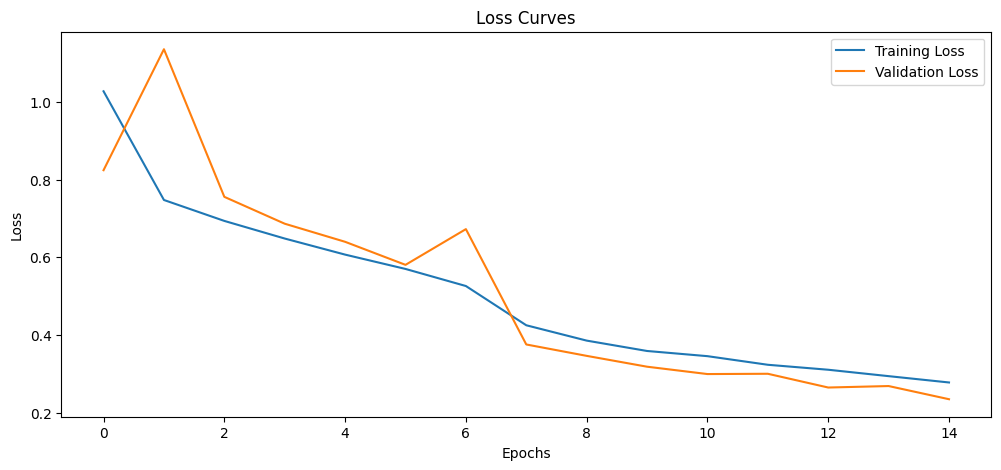

In [20]:
plt.figure(figsize=(12, 5))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Loss Curves')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

### Training and Validation Accuracy curves

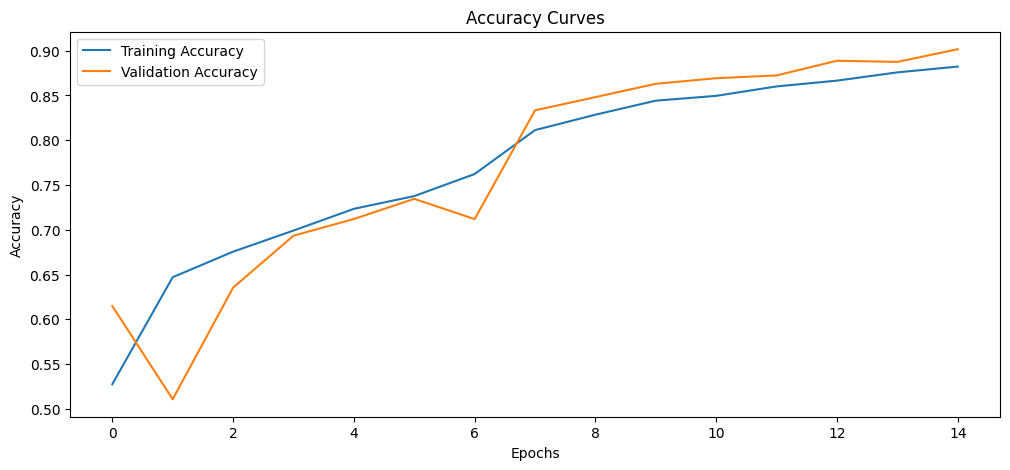

In [21]:
plt.figure(figsize=(12, 5))
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Accuracy Curves')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

### Testing the model

Testing: 100%|██████████████████████████████| 1062/1062 [04:00<00:00,  4.41it/s]


Test Accuracy: 0.9016

Classification Report:
                  precision    recall  f1-score   support

    MildDemented       0.95      0.99      0.97      8960
ModerateDemented       1.00      1.00      1.00      6464
     NonDemented       0.86      0.82      0.84      9600
VeryMildDemented       0.83      0.83      0.83      8960

        accuracy                           0.90     33984
       macro avg       0.91      0.91      0.91     33984
    weighted avg       0.90      0.90      0.90     33984



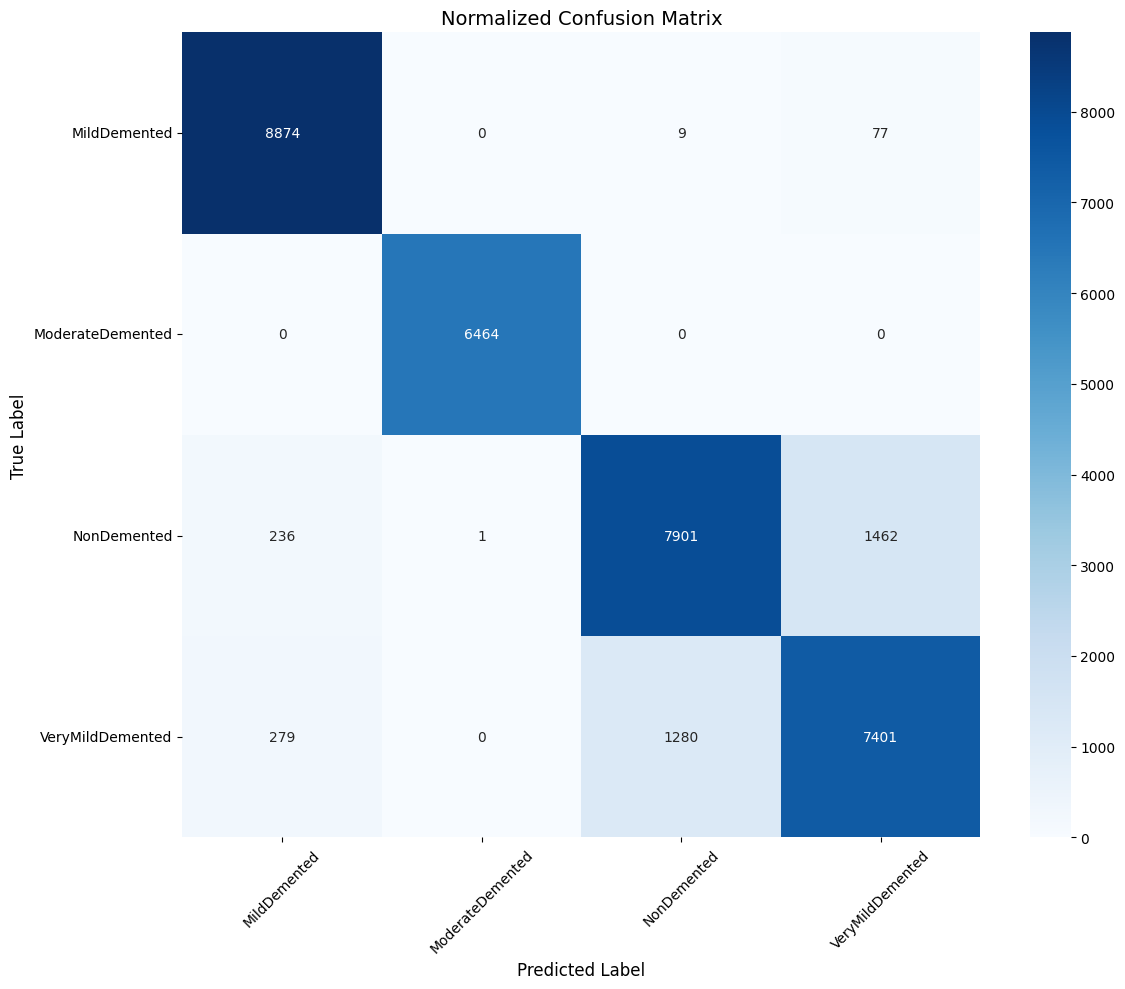

In [22]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

def test_model(model, test_loader, device, class_names):
    model.eval()
    y_true = []
    y_pred = []
    test_loss = 0.0
    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc="Testing"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
    
    accuracy = accuracy_score(y_true, y_pred)
    clf_report = classification_report(y_true, y_pred, target_names=class_names)
    cm = confusion_matrix(y_true, y_pred)

    print(f"Test Accuracy: {accuracy:.4f}")
    print(f"\nClassification Report:\n{clf_report}")
    
    plt.figure(figsize=(12,10))
    sns.heatmap(cm, annot=True, fmt=".0f", cmap='Blues', xticklabels=class_names,  yticklabels=class_names)
    plt.title('Normalized Confusion Matrix', fontsize=14)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.ylabel('True Label', fontsize=12)
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
    
    return accuracy

test_accuracy = test_model(model = model, test_loader = test_loader, device = device, class_names = test_data.classes)

### Random predictions made by the model

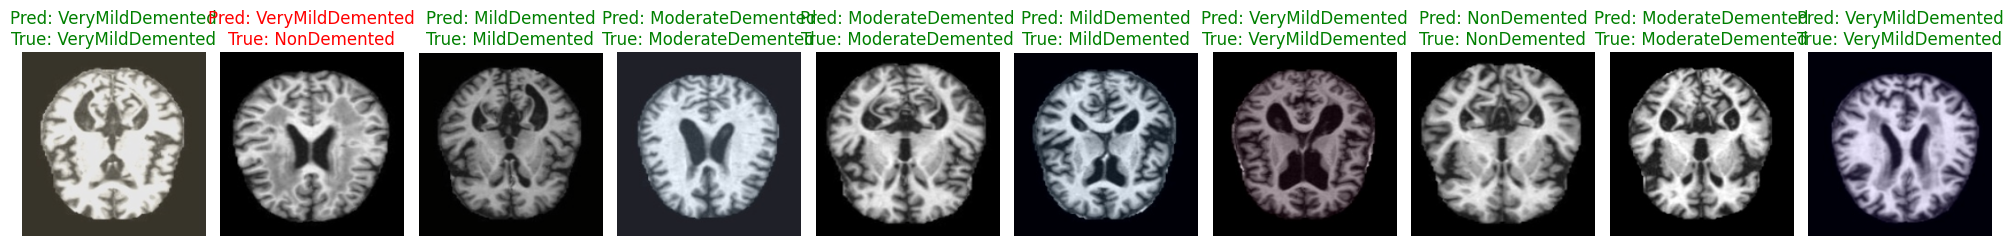

In [24]:
def visualize_random_predictions(model, data_loader, class_names, num_images=10):
    model.eval()
    class_samples = {class_idx: [] for class_idx in range(len(class_names))}
    for images, labels in data_loader:
        for img, label in zip(images, labels):
            if len(class_samples[label.item()]) < num_images:
                class_samples[label.item()].append((img, label))
        if all(len(v) >= num_images for v in class_samples.values()):
            break
    selected_samples = []
    for class_idx in class_samples:
        selected_samples.extend(random.sample(class_samples[class_idx], min(num_images, len(class_samples[class_idx]))))
    random.shuffle(selected_samples)
    fig, axes = plt.subplots(1, num_images, figsize=(20, 8))
    if num_images == 1:
        axes = [axes]
    
    for (img, true_label), ax in zip(selected_samples[:num_images], axes):
        img = img.to(device)
        img_np = img.cpu().numpy().transpose((1, 2, 0))
        img_np = img_np * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        img_np = np.clip(img_np, 0, 1)
        
        with torch.no_grad():
            output = model(img.unsqueeze(0))
            _, pred = torch.max(output, 1)
        
        ax.imshow(img_np)
        ax.set_title(f"Pred: {class_names[pred.item()]}\nTrue: {class_names[true_label.item()]}", 
                    fontsize=12, color='green' if pred == true_label else 'red')
        ax.axis("off")
    
    plt.tight_layout()
    plt.show()

class_names = ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']
visualize_random_predictions(model, val_loader, class_names, num_images=10)